<a href="https://colab.research.google.com/github/totobulu/visualization-of-graphs/blob/main/RomanEP_GCNGAT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Please, make a copy of the notebook before we start.
# Turn on the GPU support in the Runtime/Change runtime type.
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

# Install Pytorch Geometric and its dependencies
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git


2.5.1+cu121
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 31.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 20.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


## define a visualiztion function

In [ ]:
# Helper function for visualization.
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE


# Define a function to visualize both GCN and GAT embeddings
def visualize_both(embeddings_gcn, embeddings_gat, gcn_title, gat_title, color, sample_fraction=0.1):
    """
    Visualize the embeddings of both GCN and GAT models using t-SNE, sampling only a fraction of the data.

    :param embeddings_gcn: Node embeddings from GCN model
    :param embeddings_gat: Node embeddings from GAT model
    :param gcn_title: Title for the GCN plot
    :param gat_title: Title for the GAT plot
    :param color: Labels for nodes, used for coloring
    :param sample_fraction: Fraction of data to sample for plotting
    """
    # Sample a fraction of the data
    num_nodes = embeddings_gcn.shape[0]
    sample_size = int(num_nodes * sample_fraction)
    indices = torch.randperm(num_nodes)[:sample_size]

    # Apply t-SNE for dimensionality reduction on the sampled data
    tsne_gcn = TSNE(n_components=2, random_state=42).fit_transform(embeddings_gcn[indices].detach().cpu())
    tsne_gat = TSNE(n_components=2, random_state=42).fit_transform(embeddings_gat[indices].detach().cpu())

    sampled_colors = color[indices]  # Sample corresponding labels

    # Create a figure with subplots
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # Plot GCN embeddings
    scatter_gcn = axes[0].scatter(tsne_gcn[:, 0], tsne_gcn[:, 1], c=sampled_colors.cpu(), cmap='jet', s=15)
    axes[0].set_title(gcn_title)
    axes[0].axis('off')

    # Plot GAT embeddings
    scatter_gat = axes[1].scatter(tsne_gat[:, 0], tsne_gat[:, 1], c=sampled_colors.cpu(), cmap='jet', s=15)
    axes[1].set_title(gat_title)
    axes[1].axis('off')

    # Add colorbars for better interpretability
    fig.colorbar(scatter_gcn, ax=axes[0], orientation='vertical', fraction=0.046, pad=0.04)
    fig.colorbar(scatter_gat, ax=axes[1], orientation='vertical', fraction=0.046, pad=0.04)

    # Show the plots
    plt.tight_layout()
    plt.show()

    # Show the plots
    plt.show()

## load dataset

In [ ]:
from torch_geometric.datasets import HeterophilousGraphDataset

dataset = HeterophilousGraphDataset(root="data", name="Roman-empire")
print(f'Dataset: {dataset}:')
print('=========================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

Processing...


Dataset: HeterophilousGraphDataset(name=roman_empire):
Number of graphs: 1
Number of features: 300
Number of classes: 18


Done!


We can extract the first (and the only) graph, represented by PyG class [Data](https://pytorch-geometric.readthedocs.io/en/latest/modules/data.html#torch_geometric.data.Data), from the dataset object and gather some statistics about it.

In [ ]:
data = dataset[0]  # Get the first graph object.
data.train_mask=data.train_mask[:, 0]
data.val_mask=data.val_mask[:, 0]
data.test_mask=data.test_mask[:, 0]
print(data)
print(data.train_mask[0])
print('==============================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {(data.num_edges) / (2 * data.num_nodes):.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Contains isolated nodes: {data.has_isolated_nodes()}')
print(f'Contains self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Data(x=[22662, 300], edge_index=[2, 65854], y=[22662], train_mask=[22662], val_mask=[22662], test_mask=[22662])
tensor(False)
Number of nodes: 22662
Number of edges: 65854
Average node degree: 1.45
Number of training nodes: 11331
Training node label rate: 0.50
Contains isolated nodes: False
Contains self-loops: False
Is undirected: True


The `train_mask`, `val_mask`, and `test_mask` are boolean masks that indicate which nodes we should use for training, validation, and testing

## **Node classification**

The task is to infer the category of each document (18 in total), having 50%, of labeled nodes in the training set.

Let's create an MLP baseline that is applied to each node independently. This way we can verify whether adding the graph information to the model indeed improves the prediction or not. However, it might also be that the features per node are already expressive enough to clearly point towards a specific class.




We can visualize the 18-dimensional node embeddings that out untrained model produces, using the [TSNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) package that projects a high-dimensional data onto a low-dimensional plane in such a way that similar points are put close to each other.

## GCN model

In [ ]:
from torch_geometric.nn import GCNConv
from torch.nn import Linear, Dropout, ReLU

class GCN(torch.nn.Module):
    def __init__(self, c_in, c_out, c_hidden):
        super().__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(c_in, c_hidden)
        self.conv2 = GCNConv(c_hidden, c_out)
        self.dropout = Dropout(p=0.5, inplace=False)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = ReLU()(x)
        x = self.dropout(x)
        return self.conv2(x, edge_index)


## GAT model

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv

class GAT(torch.nn.Module):
    def __init__(self, in_channels: int, hidden_channels: int, out_channels: int,
                 num_heads: int = 4, dropout: float = 0.3, edge_dim: int = None):
        super().__init__()

        self.dropout = Dropout(dropout)

        # Calculate output dimensions
        self.gat1_out_channels = hidden_channels * num_heads
        self.gat2_out_channels = hidden_channels * num_heads

        # Replace BatchNorm with LayerNorm
        self.norm1 = nn.LayerNorm(self.gat1_out_channels)
        self.norm2 = nn.LayerNorm(self.gat2_out_channels)

        # Input projection for skip connection
        self.proj_skip = nn.Linear(in_channels, self.gat2_out_channels)

        self.gat1 = GATConv(
            in_channels=in_channels,
            out_channels=hidden_channels,
            heads=num_heads,
            concat=True,
            dropout=dropout,
            edge_dim=edge_dim,
            add_self_loops=False  ## The underlaying model might have self loops!!
        )

        self.gat2 = GATConv(
            in_channels=hidden_channels * num_heads,
            out_channels=hidden_channels,
            heads=num_heads,
            concat=True,
            dropout=dropout,
            add_self_loops=False
        )

        self.gat3 = GATConv(
            in_channels=hidden_channels * num_heads,
            out_channels=out_channels,# // num_heads,
            heads=num_heads,
            concat=False,
            dropout=dropout,
            add_self_loops=False
        )

    def forward(self, x, edge_index):
        # Save input for skip connection
        x_skip = x

        # GAT layer 1
        x, alpha1 = self.gat1(x, edge_index, return_attention_weights=True)
        x = F.elu(x)
        x = self.norm1(x)
        x = self.dropout(x)

        # GAT layer 2
        x_skip = self.proj_skip(x_skip)  # Align dimensions for skip connection
        x = x + x_skip  # Add skip connection
        x, alpha2 = self.gat2(x, edge_index, return_attention_weights=True)
        x = F.elu(x)
        x = self.norm2(x)
        x = self.dropout(x)

        # GAT layer 3
        x, alpha3 = self.gat3(x, edge_index, return_attention_weights=True)

        return x, [alpha1, alpha2, alpha3]

## visualize untrained GCN and GAT

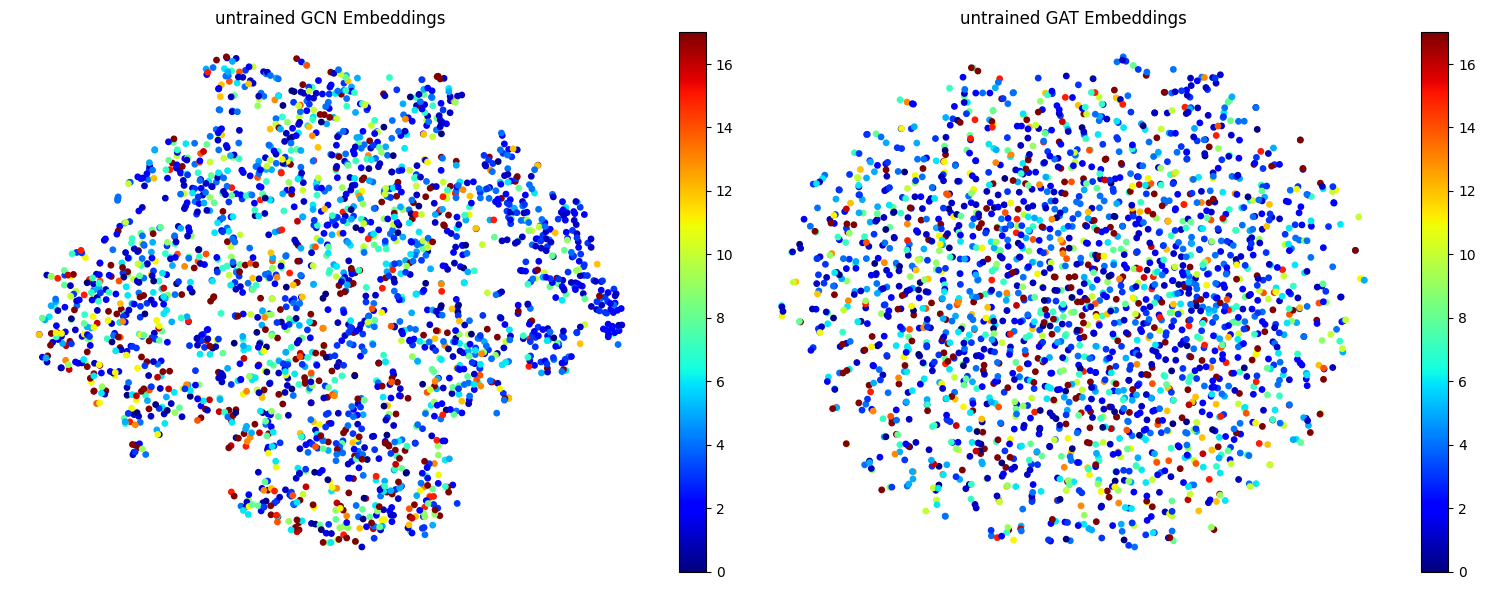

In [ ]:
c_in = dataset.num_features
c_out = dataset.num_classes
c_hidden = 16

gcn = GCN(c_in, c_out, c_hidden)
gat = GAT(c_in, c_out, c_hidden)

out_gcn = gcn(data.x, data.edge_index)
out_gat, _ = gat(data.x, data.edge_index)

# Define plot titles
gcn_title = 'untrained GCN Embeddings'
gat_title = 'untrained GAT Embeddings'

visualize_both(out_gcn, out_gat, gcn_title, gat_title, color= data.y, sample_fraction=0.1)

## Train GCN



In [ ]:
# Train the GCN
c_in = dataset.num_features
c_out = dataset.num_classes
gcn_model = GCN(c_in=c_in, c_out=c_out, c_hidden=16)
loss_function = torch.nn.CrossEntropyLoss()  # Define loss function.
optimizer = torch.optim.Adam(gcn_model.parameters(), lr=0.01, weight_decay=5e-4)  # Define optimizer.

def train():
      gcn_model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = gcn_model(data.x, data.edge_index)  # Perform a single forward pass.
      loss = loss_function(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test(mask):
      gcn_model.eval() # Set model to evalutation mode
      out = gcn_model(data.x, data.edge_index)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      correct = pred[mask] == data.y[mask]  # Check against ground-truth labels.
      acc = int(correct.sum()) / int(mask.sum())  # Derive ratio of correct predictions.
      return acc

for epoch in range(1, 201):
    train()
    train_acc = test(data.train_mask)
    val_acc= test(data.val_mask)
    test_acc = test(data.test_mask)
    print(
      f'Epoch: {epoch:03d}, Train acc: {train_acc:.4f}, '
      f'Val acc: {val_acc:.4f}, Test acc: {test_acc:4f}'
    )



Epoch: 001, Train acc: 0.0790, Val acc: 0.0738, Test acc: 0.081186
Epoch: 002, Train acc: 0.1306, Val acc: 0.1276, Test acc: 0.133074
Epoch: 003, Train acc: 0.1504, Val acc: 0.1502, Test acc: 0.159548
Epoch: 004, Train acc: 0.1570, Val acc: 0.1608, Test acc: 0.165549
Epoch: 005, Train acc: 0.1578, Val acc: 0.1603, Test acc: 0.168020
Epoch: 006, Train acc: 0.1590, Val acc: 0.1606, Test acc: 0.166078
Epoch: 007, Train acc: 0.1616, Val acc: 0.1605, Test acc: 0.165549
Epoch: 008, Train acc: 0.1611, Val acc: 0.1606, Test acc: 0.163431
Epoch: 009, Train acc: 0.1618, Val acc: 0.1622, Test acc: 0.165196
Epoch: 010, Train acc: 0.1643, Val acc: 0.1643, Test acc: 0.167490
Epoch: 011, Train acc: 0.1704, Val acc: 0.1688, Test acc: 0.174550
Epoch: 012, Train acc: 0.1795, Val acc: 0.1790, Test acc: 0.180904
Epoch: 013, Train acc: 0.1901, Val acc: 0.1896, Test acc: 0.190964
Epoch: 014, Train acc: 0.1998, Val acc: 0.2037, Test acc: 0.198906
Epoch: 015, Train acc: 0.2107, Val acc: 0.2079, Test acc: 0.21

## train GAT model

In [ ]:
# Define model, loss function, and optimizer
gat_model = GAT(in_channels=c_in, hidden_channels=16, out_channels=c_out)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(gat_model.parameters(), lr=0.01, weight_decay=5e-4)

def train():
    gat_model.train()
    optimizer.zero_grad()
    out, _ = gat_model(data.x, data.edge_index)  # Include attention outputs
    loss = loss_function(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

def test(mask):
    gat_model.eval()
    with torch.no_grad():  # Disable gradient computation
        out, _ = gat_model(data.x, data.edge_index)
        pred = out.argmax(dim=1)
        correct = (pred[mask] == data.y[mask]).sum().item()
        total = mask.sum().item()
        return correct / total

for epoch in range(1, 201):
    train_loss = train()
    train_acc = test(data.train_mask)
    val_acc = test(data.val_mask)
    test_acc = test(data.test_mask)
    print(
        f"Epoch: {epoch:03d}, Loss: {train_loss:.4f}, "
        f"Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Test Acc: {test_acc:.4f}"
    )

Epoch: 001, Loss: 2.9611, Train Acc: 0.2197, Val Acc: 0.2159, Test Acc: 0.2169
Epoch: 002, Loss: 2.6796, Train Acc: 0.2449, Val Acc: 0.2397, Test Acc: 0.2432
Epoch: 003, Loss: 2.5731, Train Acc: 0.2648, Val Acc: 0.2613, Test Acc: 0.2635
Epoch: 004, Loss: 2.5024, Train Acc: 0.2888, Val Acc: 0.2867, Test Acc: 0.2912
Epoch: 005, Loss: 2.4549, Train Acc: 0.3037, Val Acc: 0.2962, Test Acc: 0.3032
Epoch: 006, Loss: 2.4028, Train Acc: 0.3136, Val Acc: 0.3093, Test Acc: 0.3073
Epoch: 007, Loss: 2.3572, Train Acc: 0.3235, Val Acc: 0.3218, Test Acc: 0.3205
Epoch: 008, Loss: 2.3195, Train Acc: 0.3356, Val Acc: 0.3310, Test Acc: 0.3309
Epoch: 009, Loss: 2.2833, Train Acc: 0.3422, Val Acc: 0.3398, Test Acc: 0.3371
Epoch: 010, Loss: 2.2460, Train Acc: 0.3501, Val Acc: 0.3465, Test Acc: 0.3443
Epoch: 011, Loss: 2.1979, Train Acc: 0.3637, Val Acc: 0.3569, Test Acc: 0.3517
Epoch: 012, Loss: 2.1677, Train Acc: 0.3768, Val Acc: 0.3723, Test Acc: 0.3625
Epoch: 013, Loss: 2.1485, Train Acc: 0.3897, Val Acc

## visualize trained GCN and GAT

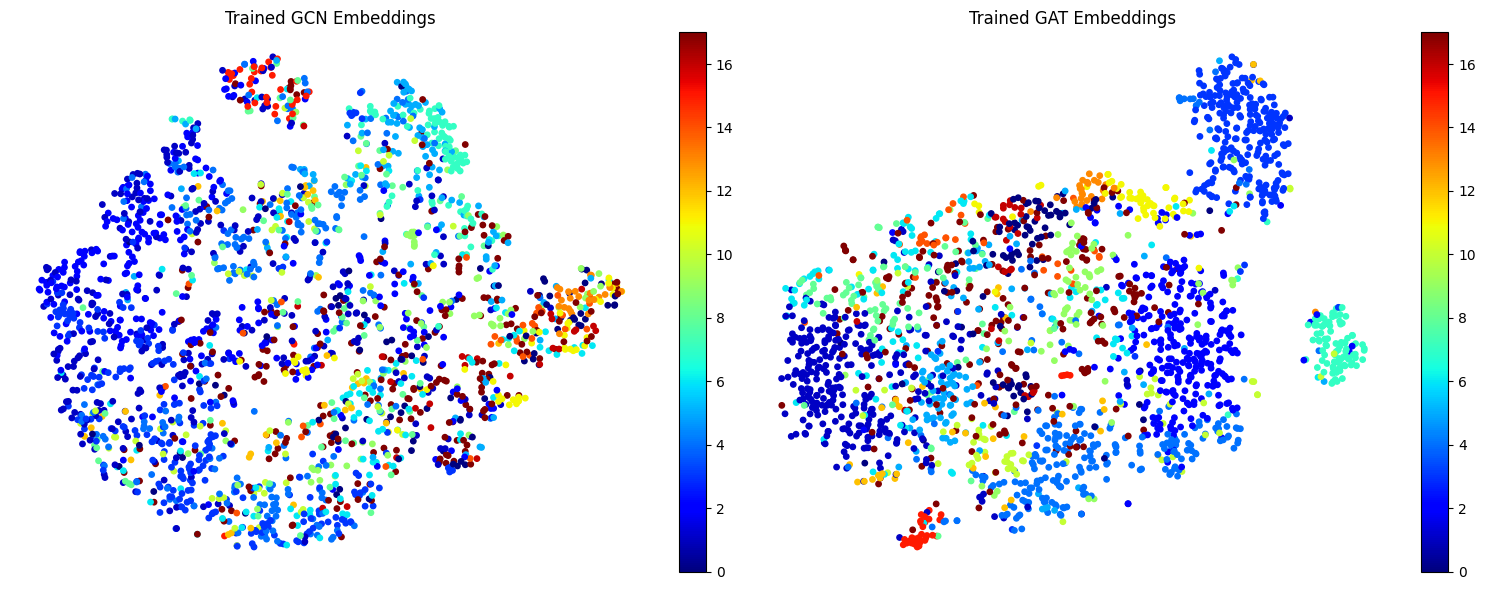

In [ ]:


# Assuming GCN and GAT models are trained and in evaluation mode
c_in = dataset.num_features
c_out = dataset.num_classes

# Switch both models to evaluation mode
gcn_model.eval()
gat_model.eval()

# Get embeddings from the GCN and GAT models
with torch.no_grad():
    out_gcn = gcn_model(data.x, data.edge_index)  # For GCN
    out_gat, _ = gat_model(data.x, data.edge_index)  # For GAT, also discard attention weights

# Define plot titles
gcn_title = 'Trained GCN Embeddings'
gat_title = 'Trained GAT Embeddings'

# Call the visualization function
visualize_both(out_gcn, out_gat, gcn_title, gat_title, color=data.y, sample_fraction=0.1)